# Introduction to PyTorch

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

## Linear regression

### Data preparation


In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
X = torch.tensor(boston['data'], dtype=torch.float)
y = torch.tensor(boston['target'], dtype=torch.float)

In [ ]:
n, p = X.shape
n_train = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
X = X[indices]
y = y[indices]
X_train = X[:n_train, :]
y_train = y[:n_train]
X_validation = X[n_train:n_train+n_validation, :]
y_validation = y[n_train:n_train+n_validation]
X_test = X[n_train+n_validation:, :]
y_test = y[n_train+n_validation:]

### Building a simple regressor


In [ ]:
regressor = nn.Linear(p, 1) # p input features, 1 output feature

In [ ]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, prediction, target):
        return ((prediction-target)**2).mean()

mse = MSE()

In [ ]:
opt = optim.Adam(regressor.parameters())

In [ ]:
mse_values = []
batch_size = 100
n_epoch = 1000
for epoch in range(n_epoch):
    indices = np.random.permutation(n_train)
    mse_epoch = []
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        indices_batch = indices[start:end]
        X_batch = X_train[indices_batch, :]
        y_batch = y_train[indices_batch]
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.detach())
    mse_values.append(np.mean(mse_epoch))    

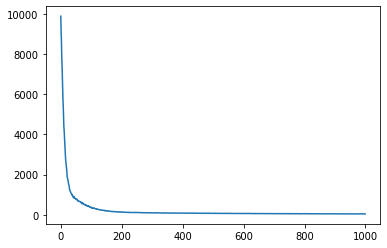

In [ ]:
plt.plot(mse_values)
plt.show()

###  Early stopping

In [ ]:
regressor = nn.Linear(p, 1) # p input features, 1 output feature
opt = optim.Adam(regressor.parameters())

batch_size = 100
n_epoch = 10000
training_mses = []
validation_mses = []
best = np.inf
counter = 0
for epoch in range(n_epoch):
    regressor.train()
    indices = np.random.permutation(n_train)
    mse_epoch = []
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        indices_batch = indices[start:end]
        X_batch = X_train[indices_batch, :]
        y_batch = y_train[indices_batch]
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        mse_epoch.append(mse_value.detach())
        opt.step()
    training_mses.append(np.mean(mse_epoch))  
    regressor.eval()
    y_pred = regressor(X_validation).reshape((-1,))
    mse_value = mse(y_pred, y_validation)
    current = mse_value.detach()
    if current < best:
        best = current
        counter = 0
    if counter == 100:
        print("Epoch number: ", epoch)
        break
    counter+=1
    validation_mses.append(current)


Epoch number:  3934


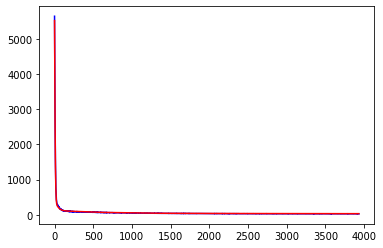

In [ ]:
plt.plot(training_mses, 'b') # plot training errors in blue
plt.plot(validation_mses, 'r') # plot validation errors in red
plt.show()

### L1 regularization

In [ ]:
class MSEWithL1(nn.Module):
    
    def __init__(self, alpha, weight):
        super(MSEWithL1, self).__init__()
        self._weight = weight
        self._alpha = alpha
        
    def forward(self, pred, target):
        return ((pred-target)**2).mean() + self._alpha*torch.sum(torch.abs(self._weight[1:]))
    

In [ ]:
mse = MSE()

mses = {}
for alpha in [0.01, 0.1, 1, 10, 100]:    
    regressor = nn.Linear(p, 1) 
    opt = optim.Adam(regressor.parameters())
    cost = MSEWithL1(alpha, regressor.weight)
    training_mses = []
    validation_mses = []
    batch_size = 100
    n_epoch = 5000
    for epoch in range(n_epoch):
        regressor.train()
        mse_epoch =[]
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            indices_batch = indices[start:end]
            X_batch = X_train[indices_batch, :]
            y_batch = y_train[indices_batch]
            opt.zero_grad()
            y_pred = regressor(X_batch).reshape((-1,))
            mse_value = cost(y_pred, y_batch)
            mse_value.backward()
            opt.step()
        regressor.eval()
        y_pred = regressor(X_validation).reshape((-1,))
        mse_value = mse(y_pred, y_validation)
        validation_mses.append(mse_value.detach())
    mses[alpha] = validation_mses

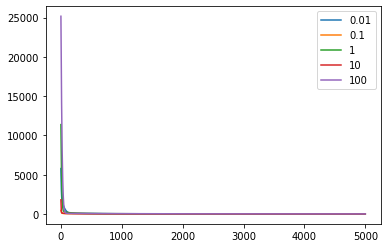

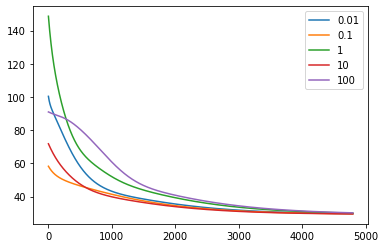

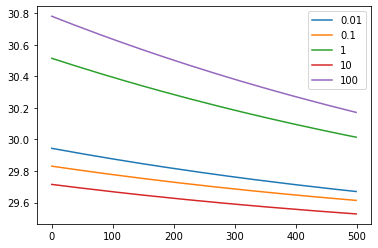

In [ ]:
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha][200:])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha][4500:])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()

## Classification

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
X = torch.tensor(mnist.data, dtype=torch.float)
y = torch.tensor([int(v) for v in mnist.target])

In [ ]:
n, p = mnist.data.shape
k = 10 # liczba klas
n_train = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
train_indices = indices[:n_train]
validation_indices = indices[n_train:n_train+n_validation]
test_indices = indices[n_train+n_validation:]

ds_train = data.TensorDataset(X[train_indices,:], y[train_indices])
ds_validation = data.TensorDataset(X[validation_indices,:], y[validation_indices])
ds_test = data.TensorDataset(X[test_indices,:], y[test_indices])

### Logistic regression

In [ ]:
model = nn.Linear(p, k)

In [ ]:
cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

In [ ]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [ ]:
loss_values = []
acc_values = []
batch_size = 100
n_epoch = 100

In [ ]:
for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)

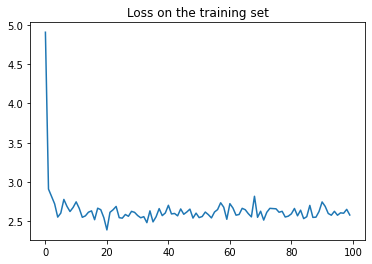

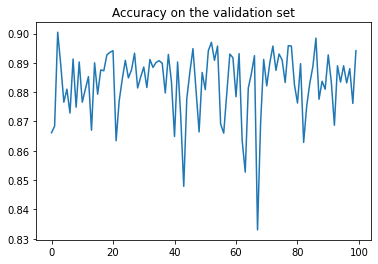

In [ ]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

In [ ]:
loss_values = []
acc_values = []
batch_size = 100
n_epoch = 100
best_acc = -np.inf
counter = 0
patience = 35

In [ ]:
for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    if acc > best_acc:
        best_acc = acc
        counter = 0
    if counter == patience:
        break
    counter +=1
    acc_values.append(float(acc))

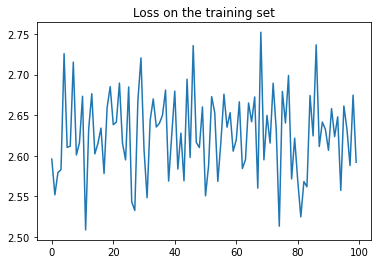

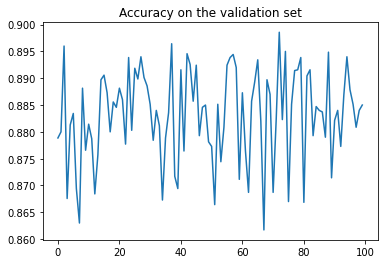

In [ ]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

###  A neural network with a hidden layer

In [1]:
loss_values = []
acc_values = []
batch_size = 100
n_epoch = 100
best_acc = -np.inf
counter = 0
patience = 35

NameError: ignored

In [ ]:
model_with_hidden = torch.nn.Sequential(
    nn.Linear(p, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 10),
    nn.LeakyReLU(),
    nn.LogSoftmax(dim=1)
)
cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model_with_hidden.parameters())

In [ ]:
for epoch in range(n_epoch):
    model_with_hidden.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model_with_hidden(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model_with_hidden.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model_with_hidden(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    if acc > best_acc:
        best_acc = acc
        counter = 0
    if counter == patience:
        break
    counter +=1
    acc_values.append(float(acc))

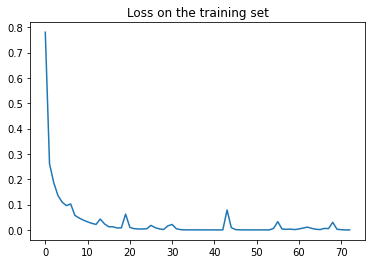

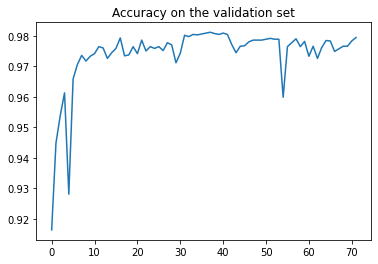

In [ ]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()